# Convolutional Autoencoders

In this notebook, we will use convolutional layers to build our autoencoder. This approach typically yields better results than dense networks because convolutional layers are more effective at capturing spatial hierarchies in images, making them particularly well-suited for image data. We will see this in action with the [Fashion MNIST dataset](https://www.tensorflow.org/datasets/catalog/fashion_mnist).

## Imports

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt

## Prepare the Dataset

We will load the train and test sets from TFDS like we have done in the other notebooks. One key change is that we won't flatten the images this time. That's because we will be using convolutional layers later that can process 2D images effectively.

In [ ]:
def map_image(image, label):
  '''Normalizes the image. Returns image as input and label.'''
  image = tf.cast(image, dtype=tf.float32)
  image = image / 255.0

  return image, image

In [ ]:
BATCH_SIZE = 128
SHUFFLE_BUFFER_SIZE = 1024

train_dataset = tfds.load('fashion_mnist', as_supervised=True, split="train")
train_dataset = train_dataset.map(map_image)
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).repeat()

test_dataset = tfds.load('fashion_mnist', as_supervised=True, split="test")
test_dataset = test_dataset.map(map_image)
test_dataset = test_dataset.batch(BATCH_SIZE).repeat()

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/incomplete.67OO6S_3.0.1/fashion_mnist-train.tfrecord*...:   …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/incomplete.67OO6S_3.0.1/fashion_mnist-test.tfrecord*...:   0…

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


## Define the Model

We will use convolutional layers to build the model, which consists of three main parts: encoder, bottleneck, and decoder. We will follow the configuration shown in the image below.

<img src="https://drive.google.com/uc?export=view&id=15zh7bst9KKvciRdCvMAH7kXt3nNkABzO" width="75%" height="75%"/>

The encoder will contract with each additional layer. The Conv2D layers will generate features, extracting relevant patterns from the image. The max pooling layers will reduce the dimensionality, progressively making the image smaller and more abstract, focusing on essential features and reducing spatial dimensions.

In [ ]:
def encoder(inputs):
  '''Defines the encoder with two Conv2D and max pooling layers.'''
  conv_1 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(inputs)
  max_pool_1 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(conv_1)

  conv_2 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same')(max_pool_1)
  max_pool_2 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(conv_2)

  return max_pool_2

The bottleneck layer is used to obtain a more compact representation of the input features without further reducing the dimension. This layer acts as a compressed knowledge representation, capturing the most critical information of the input. An additional layer is included here to visualize the output of the encoder, providing insights into what features the encoder has learned.

In [ ]:
def bottle_neck(inputs):
  '''Defines the bottleneck.'''
  bottle_neck = tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same')(inputs)
  encoder_visualization = tf.keras.layers.Conv2D(filters=1, kernel_size=(3,3), activation='sigmoid', padding='same')(bottle_neck)

  return bottle_neck, encoder_visualization

The decoder will then upsample the bottleneck output back to the original image size. This process involves increasing the spatial dimensions of the encoded image, reconstructing it to match the input size. The decoder utilizes Conv2DTranspose layers to reverse the pooling effect, ensuring that the output image closely resembles the input.

In [ ]:
def decoder(inputs):
  '''Defines the decoder path to upsample back to the original image size.'''
  conv_1 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same')(inputs)
  up_sample_1 = tf.keras.layers.UpSampling2D(size=(2,2))(conv_1)

  conv_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(up_sample_1)
  up_sample_2 = tf.keras.layers.UpSampling2D(size=(2,2))(conv_2)

  conv_3 = tf.keras.layers.Conv2D(filters=1, kernel_size=(3,3), activation='sigmoid', padding='same')(up_sample_2)

  return conv_3

We can now build the full autoencoder by combining these functions, constructing a model that efficiently compresses and decompresses the input data.

In [ ]:
def convolutional_auto_encoder():
  '''Builds the entire autoencoder model.'''
  inputs = tf.keras.layers.Input(shape=(28, 28, 1,))
  encoder_output = encoder(inputs)
  bottleneck_output, encoder_visualization = bottle_neck(encoder_output)
  decoder_output = decoder(bottleneck_output)

  model = tf.keras.Model(inputs =inputs, outputs=decoder_output)
  encoder_model = tf.keras.Model(inputs=inputs, outputs=encoder_visualization)
  return model, encoder_model


In [ ]:
convolutional_model, convolutional_encoder_model = convolutional_auto_encoder()
convolutional_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 128)         0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 256)         295168

## Compile and Train the model

In [ ]:
train_steps = 60000 // BATCH_SIZE
valid_steps = 60000 // BATCH_SIZE

convolutional_model.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy')
conv_model_history = convolutional_model.fit(train_dataset, steps_per_epoch=train_steps, validation_data=test_dataset, validation_steps=valid_steps, epochs=50)

Epoch 1/50
468/468 [==============================] - 18s 26ms/step - loss: 0.2913 - val_loss: 0.2670
Epoch 2/50
468/468 [==============================] - 11s 22ms/step - loss: 0.2613 - val_loss: 0.2601
Epoch 3/50
468/468 [==============================] - 11s 24ms/step - loss: 0.2564 - val_loss: 0.2576
Epoch 4/50
468/468 [==============================] - 10s 22ms/step - loss: 0.2538 - val_loss: 0.2548
Epoch 5/50
468/468 [==============================] - 9s 20ms/step - loss: 0.2521 - val_loss: 0.2549
Epoch 6/50
468/468 [==============================] - 10s 22ms/step - loss: 0.2510 - val_loss: 0.2525
Epoch 7/50
468/468 [==============================] - 10s 22ms/step - loss: 0.2502 - val_loss: 0.2523
Epoch 8/50
468/468 [==============================] - 10s 22ms/step - loss: 0.2495 - val_loss: 0.2510
Epoch 9/50
468/468 [==============================] - 12s 26ms/step - loss: 0.2490 - val_loss: 0.2510
Epoch 10/50
468/468 [==============================] - 10s 21ms/step - loss: 0.2485

## Display sample results

In [ ]:
def display_one_row(disp_images, offset, shape=(28, 28)):
  '''Display sample outputs in one row.'''
  for idx, test_image in enumerate(disp_images):
    plt.subplot(3, 10, offset + idx + 1)
    plt.xticks([])
    plt.yticks([])
    test_image = np.reshape(test_image, shape)
    plt.imshow(test_image, cmap='gray')


def display_results(disp_input_images, disp_encoded, disp_predicted, enc_shape=(8,4)):
  '''Displays the input, encoded, and decoded output values.'''
  plt.figure(figsize=(15, 5))
  display_one_row(disp_input_images, 0, shape=(28,28,))
  display_one_row(disp_encoded, 10, shape=enc_shape)
  display_one_row(disp_predicted, 20, shape=(28,28,))

1/1 [==============================] - 0s 213ms/step


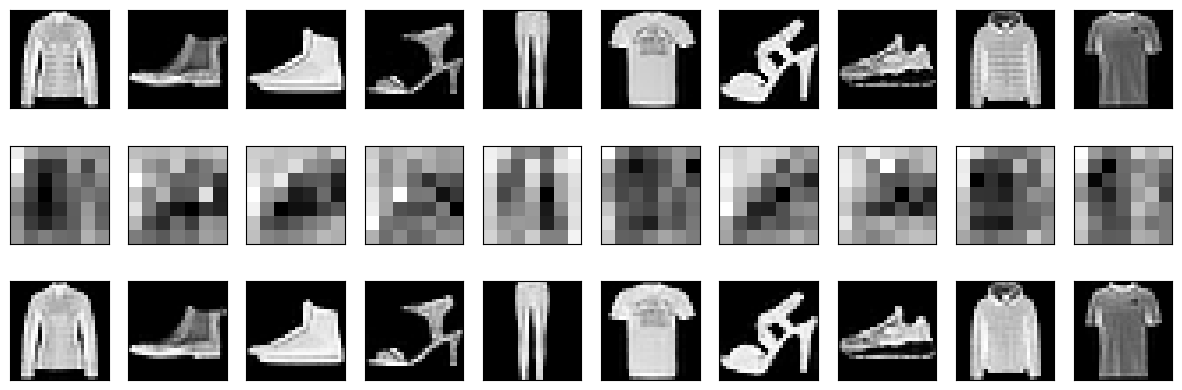

In [ ]:
# Take 1 batch of the dataset
test_dataset = test_dataset.take(1)

# Take the input images and put them in a list
output_samples = []
for input_image, image in tfds.as_numpy(test_dataset):
      output_samples = input_image

# Pick 10 indices
idxs = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

# Prepare test samples as a batch of 10 images
conv_output_samples = np.array(output_samples[idxs])
conv_output_samples = np.reshape(conv_output_samples, (10, 28, 28, 1))

# Get the encoder ouput
encoded = convolutional_encoder_model.predict(conv_output_samples)

# Get a prediction for some values in the dataset
predicted = convolutional_model.predict(conv_output_samples)

# Display the samples, encodings and decoded values
display_results(conv_output_samples, encoded, predicted, enc_shape=(7,7))